In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import copy
import sys
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import train_test_split
import ipyvolume as ipv


In [2]:
fileroot='2024_03_08_TRF_Maleen/'
filename='2024_03_08_TRF_Maleen_01'

datapath='/home/maleen/research_data/Transformers/datasets/training/'

# Load the DataFrame from the pickle file
df1 = pd.read_pickle(datapath + filename + '.pkl')

arrays = [np.array(item) for item in df1['Skeleton_3D']]
timestamps = [np.array(item) for item in df1['Skeleton_Timestamp']]

# Convert datetime to seconds from start
timestamps = (timestamps - timestamps[0])

# Stack these arrays along a new axis to create a 3D NumPy array
# Each "slice" of this 3D array represents one frame of keypoints
skeleton_3d_frames = np.stack(arrays, axis=0)

In [3]:
# Assume skeleton_3d_frames is already defined
# skeleton_3d_frames shape is (1020, 18, 3)

# Indices of the joints to be removed
joints_to_remove = [9, 10, 12, 13]

# Create a mask to keep the joints that are not to be removed
mask = np.ones(skeleton_3d_frames.shape[1], dtype=bool)
mask[joints_to_remove] = False

# Update skeleton_3d_frames to remove the specified joints
skeleton_3d_frames_updated = skeleton_3d_frames[:, mask, :]

# Original connections
original_connections = [
    (16, 14), (14, 0),               # Right Head
    (17, 15), (15, 0),               # Left Head
    (0, 1),                          # Neck
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8), (8, 9), (9, 10),         # Right leg
    (1, 11), (11, 12), (12, 13),     # Left leg
    (8, 11)                          # Between hips
]

# Mapping of old joint indices to new indices
index_mapping = {}
new_index = 0
for old_index in range(skeleton_3d_frames.shape[1]):
    if old_index not in joints_to_remove:
        index_mapping[old_index] = new_index
        new_index += 1

# Update the connections to reflect the new indices
new_connections = []
for connection in original_connections:
    if connection[0] in index_mapping and connection[1] in index_mapping:
        new_connections.append((index_mapping[connection[0]], index_mapping[connection[1]]))

# Print the updated connections
print("Updated skeleton_3d_frames shape:", skeleton_3d_frames_updated.shape)
print("Updated connections:", new_connections)


Updated skeleton_3d_frames shape: (1020, 14, 3)
Updated connections: [(12, 10), (10, 0), (13, 11), (11, 0), (0, 1), (1, 2), (2, 3), (3, 4), (1, 5), (5, 6), (6, 7), (1, 8), (1, 9), (8, 9)]


In [4]:
# Check if there are any NaN values in skeleton_3d_frames_updated
nan_indices = np.isnan(skeleton_3d_frames_updated)

# Find the indices of frames and joints that have NaN values
frames_with_nans, joints_with_nans, _ = np.where(nan_indices)

# Create a set of unique joints that have NaN values
unique_joints_with_nans = set(joints_with_nans)

print("Frames with NaN values:", np.unique(frames_with_nans))
print("Joints with NaN values:", unique_joints_with_nans)

# Find the indices of frames that have NaN values
frames_with_nans = np.unique(np.where(nan_indices)[0])

# Remove the frames with NaN values
skeleton_3d_frames_cleaned = np.delete(skeleton_3d_frames_updated, frames_with_nans, axis=0)
timestamps_cleaned=np.delete(timestamps, frames_with_nans, axis=0)

print("Original shape:", skeleton_3d_frames_updated.shape)
print("New shape after removing frames with NaNs:", skeleton_3d_frames_cleaned.shape)

Frames with NaN values: [   0    1   49   89   90   91   92   93   94   95   96   97   98   99
  100  143  144  145  208  231  232  233  234  239  289  296  325  326
  327  328  329  330  331  332  333  334  337  338  345  346  347  348
  349  350  351  352  353  354  355  356  357  358  359  360  361  362
  363  364  365  366  367  368  369  370  371  372  373  374  375  376
  377  378  379  380  381  382  383  384  385  386  387  388  389  390
  391  392  393  395  422  423  424  425  426  549  550  551  552  553
  554  555  556  557  558  559  560  561  562  563  564  565  566  567
  568  569  570  571  572  573  578  582  669  670  671  672  673  674
  675  676  677  678  679  680  681  685  686  687  688  690  694  695
  696  697  738  739  740  741  742  743  744  745  746  747  748  749
  750  751  752  753  754  755  860  861  862  863  864  865  866  867
  868  872  938 1018 1019]
Joints with NaN values: {2, 4, 6, 7, 13}
Original shape: (1020, 14, 3)
New shape after removing f

In [5]:
# Calculate the differences in position and time
position_diff = np.diff(skeleton_3d_frames_cleaned, axis=0)
time_diff = np.diff(timestamps_cleaned)

# Ensure that time_diff is of shape (n,1,1) so that it broadcasts correctly when dividing
time_diff = time_diff[:, np.newaxis, np.newaxis]


# Now we calculate velocity, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_vel = position_diff / time_diff

# Calculate the differences in velocity
velocity_diff = np.diff(skel_vel, axis=0)

# Now we calculate acceleration, handling missing data according to the mask
# Where the mask is False, we will get np.nan
skel_acc = velocity_diff / time_diff[:-1, :, :]  # Use time_diff with one less time dimension

skel_pos= skeleton_3d_frames_cleaned[2:]
skel_vel = skel_vel[1:]

In [6]:
# Now, slice skeleton_3d_frames and skel_vel to match the dimensions of skell_acc
print(skel_pos.shape)
print(skel_vel.shape)
print(skel_acc.shape)

(845, 14, 3)
(845, 14, 3)
(845, 14, 3)


In [7]:
# Initialize arrays to hold the normalized data, medians, and IQRs
norm_pos = np.empty_like(skel_pos)
medians_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))
iqrs_per_joint_axis_skel_pos = np.empty((skel_pos.shape[1], skel_pos.shape[2]))

norm_vel= np.empty_like(skel_vel)
medians_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))
iqrs_per_joint_axis_vel = np.empty((skel_vel.shape[1], skel_vel.shape[2]))

norm_acc = np.empty_like(skel_acc)
medians_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))
iqrs_per_joint_axis_acc = np.empty((skel_acc.shape[1], skel_acc.shape[2]))

def robust_normalize_data_with_clipping(data, medians_per_joint_axis, iqrs_per_joint_axis, normalized_data, clipping_percentiles=(1, 99)):
    for joint in range(data.shape[1]):  # For each joint
        for axis in range(data.shape[2]):  # For each axis (x, y, z)
            joint_axis_data = data[:, joint, axis]

            # Determine clipping thresholds based on percentiles
            lower_threshold, upper_threshold = np.percentile(joint_axis_data, clipping_percentiles)

            # Clip the data based on thresholds
            clipped_values = np.clip(joint_axis_data, lower_threshold, upper_threshold)

            # Calculate median and IQR for clipped data
            median = np.median(clipped_values)
            q75, q25 = np.percentile(clipped_values, [75, 25])
            iqr = q75 - q25

            # Store the calculated medians and IQRs
            medians_per_joint_axis[joint, axis] = median
            iqrs_per_joint_axis[joint, axis] = iqr

            # Normalize the clipped data, avoiding division by zero
            if iqr > 0:
                normalized_values = (clipped_values - median) / iqr
            else:
                normalized_values = clipped_values  # Keep original values if IQR is 0

            # Store the normalized values
            normalized_data[:, joint, axis] = normalized_values

    return normalized_data, medians_per_joint_axis, iqrs_per_joint_axis
# Example usage with your data
# Note: masks, skel_pos, skel_vel, skel_acc should be defined in your context

norm_pos, medians_pos, iqrs_pos = robust_normalize_data_with_clipping(skel_pos, medians_per_joint_axis_skel_pos, iqrs_per_joint_axis_skel_pos, norm_pos)
norm_vel, medians_vel, iqrs_vel = robust_normalize_data_with_clipping(skel_vel, medians_per_joint_axis_vel, iqrs_per_joint_axis_vel, norm_vel)
norm_acc, medians_acc, iqrs_acc = robust_normalize_data_with_clipping(skel_acc, medians_per_joint_axis_acc, iqrs_per_joint_axis_acc, norm_acc)


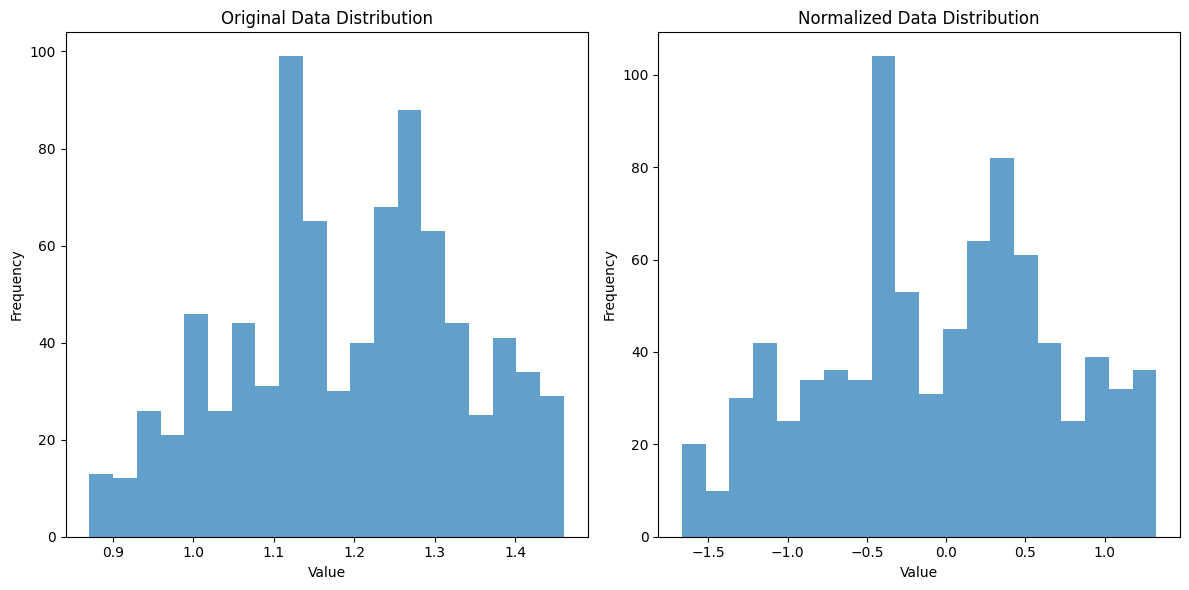

Median of normalized data: 0.0
Data points within [-1, 1] (IQR): 845 out of 845
Original Data points within [-1, 1] (IQR): 98 out of 845


In [8]:
data=skel_pos
norm_data=norm_pos
# Plot the original and normalized data for a specific joint and axis
joint, axis = 0, 0  # Change as needed
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(data[:, joint, axis], bins=20, alpha=0.7, label='Original')
plt.title("Original Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(norm_data[:, joint, axis], bins=20, alpha=0.7, label='Normalized')
plt.title("Normalized Data Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Check the median and range of the normalized data
normalized_median = np.nanmedian(norm_data[:, joint, axis])
print("Median of normalized data:", normalized_median)

within_iqr = ((norm_data[:, joint, axis] > -2) & (norm_data[:, joint, axis] < 2)).sum()
print(f"Data points within [-1, 1] (IQR): {within_iqr} out of {norm_data.shape[0]}")

within_iqr2 = ((data[:, joint, axis] > -1) & (data[:, joint, axis] < 1)).sum()
print(f"Original Data points within [-1, 1] (IQR): {within_iqr2} out of {norm_data.shape[0]}")

In [9]:
np.shape(norm_pos)

(845, 14, 3)

In [10]:
class SkeletalInputEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim=128, device='cuda'):
        super(SkeletalInputEmbedding, self).__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        self.device = device

        # Linear layer to project input_dim to embed_dim
        self.input_embed = nn.Linear(input_dim, embed_dim)

    def forward(self, joint_positions):
        # joint_positions shape: (batch_size, seq_len, num_joints, dof)
        batch_size, seq_len, num_joints, dof = joint_positions.size()
        input_dim = num_joints * dof  # Total input dimension

        # Reshape to (batch_size * seq_len, num_joints * dof)
        joint_positions = joint_positions.view(batch_size * seq_len, input_dim)

        # Apply the linear layer to project to embed_dim
        embeddings = self.input_embed(joint_positions)

        # Reshape back to (batch_size, seq_len, embed_dim)
        embeddings = embeddings.view(batch_size, seq_len, self.embed_dim)

        # Calculate positional encoding
        positional_encoding = self.get_sinusoidal_encoding(seq_len, self.embed_dim).to(self.device)
        positional_encoding = positional_encoding.unsqueeze(0).expand(batch_size, seq_len, self.embed_dim)

        # Add positional encoding to the embeddings
        embeddings += positional_encoding

        return embeddings

    def get_sinusoidal_encoding(self, total_len, embed_dim):
        position = torch.arange(0, total_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim))
        
        pe = torch.zeros(total_len, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        return pe

In [11]:
class TargetEmbedding(nn.Module):
    def __init__(self, num_joints=18, dof=3, embed_dim=128, device='gpu'):
        super().__init__()
        self.num_joints = num_joints
        self.dof = dof
        self.embed_dim = embed_dim
        self.device = device  # Store the device

        self.joint_embed = nn.Linear(dof, embed_dim)
        # self.vel_embed = nn.Linear(dof, embed_dim)
        # self.acc_embed = nn.Linear(dof, embed_dim)

    #def forward(self, joint_positions, velocities, accelerations, mask=None):
    def forward(self, joint_positions, mask=None):
        # Replace NaNs in the input data
        joint_positions = torch.nan_to_num(joint_positions)
        # velocities = torch.nan_to_num(velocities)
        # accelerations = torch.nan_to_num(accelerations)


        # Embedding and combining the embeddings
        joint_embeddings = self.joint_embed(joint_positions)
        # vel_embeddings = self.vel_embed(velocities)
        # acc_embeddings = self.acc_embed(accelerations)
        combined_embeddings = joint_embeddings #+ vel_embeddings + acc_embeddings

        # # Apply mask after NaN replacement
        # if mask is not None:
        #     mask = mask.unsqueeze(-1)  # Add a dimension for the features
        #     combined_embeddings = combined_embeddings * mask

        # Calculate positional encoding dynamically
        seq_len = joint_positions.size(1)  # Assuming joint_positions is [seq_len, num_joints, dof]
        positional_encoding = self.get_sinusoidal_encoding(seq_len, self.num_joints*self.embed_dim)
        # print("Device of input embeddings:", combined_embeddings.device)
        # print("Device of positional encodings:", positional_encoding.device)

        positional_encoding = positional_encoding.view(seq_len, self.num_joints, self.embed_dim)

        combined_embeddings += positional_encoding.unsqueeze(0)  # Unsqueeze to add batch dimension for broadcasting
        combined_embeddings = combined_embeddings.view(-1, seq_len, self.num_joints, self.embed_dim)

        return combined_embeddings

    def get_sinusoidal_encoding(self, total_len, embed_dim):
        # Make sure the position tensor is created on the right device
        position = torch.arange(0, total_len, dtype=torch.float, device=self.device).unsqueeze(1)
    
        # Calculate the division term for sinusoidal encoding
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * -(np.log(10000.0) / embed_dim)).to(self.device)
        div_term = div_term.unsqueeze(0)  # Reshape for broadcasting
    
        # Create the positional encoding matrix
        pe = torch.zeros(total_len, embed_dim, device=self.device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
    
        return pe



In [12]:
class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        
        # Transformer Encoder Layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.embed_dim,
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        """
        src: Tensor of shape (batch_size, seq_len, embed_dim)
        src_mask: None or Tensor for masking in multi-head attention (not used in this example)
        src_key_padding_mask: Tensor of shape (batch_size, seq_len) indicating which elements are padded
        """
        # Applying Transformer Encoder
        output = self.transformer_encoder(src, mask=src_mask, src_key_padding_mask=src_key_padding_mask)
        
        return output

In [13]:
class TransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, num_joints, dropout_rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate
        self.num_joints = num_joints

        # Transformer Decoder Layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=self.embed_dim,  # Keeping d_model consistent with embed_dim
            nhead=self.num_heads,
            dropout=self.dropout_rate,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=self.num_layers)

        # Output layer to convert decoder output to joint position dimension
        self.output_layer = nn.Linear(self.embed_dim, self.num_joints * 3)  # Assuming output per joint is a 3D position

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt: Tensor of shape (batch_size, output_seq_len, embed_dim), initially could be start token or zero vectors
        memory: Tensor of shape (batch_size, input_seq_len, embed_dim), output from the Transformer encoder
        tgt_mask: Mask to ensure the decoder's predictions are based only on past positions
        memory_mask: Optional, to mask encoder outputs if necessary
        tgt_key_padding_mask: Tensor of shape (batch_size, output_seq_len) for masking target sequences
        memory_key_padding_mask: Tensor of shape (batch_size, input_seq_len) for masking memory sequences
        """

        # Transformer Decoder
        output = self.transformer_decoder(
            tgt, memory, tgt_mask=tgt_mask, memory_mask=memory_mask,
            tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask
        )

        # Project to joint position dimensions
        output = self.output_layer(output)

        # Reshape to (batch_size, seq_len, num_joints, 3)
        output = output.view(output.size(0), output.size(1), self.num_joints, 3)

        return output

In [14]:
def generate_sequences(norm_pos, norm_vel, norm_acc, input_length=60, predict_length=60):
    num_frames = norm_pos.shape[0]
    num_joints = norm_pos.shape[1]

    # Calculate the total number of sequences we can create
    num_sequences = num_frames - input_length - predict_length + 1

    # Initialize arrays to store the input and target sequences
    X_pos = np.zeros((num_sequences, input_length, num_joints, 3))
    X_vel = np.zeros((num_sequences, input_length, num_joints, 3))
    X_acc = np.zeros((num_sequences, input_length, num_joints, 3))
    Y_pos = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_vel = np.zeros((num_sequences, predict_length, num_joints, 3))
    Y_acc = np.zeros((num_sequences, predict_length, num_joints, 3))
    # X_mask = np.zeros((num_sequences, input_length, num_joints))
    # Y_mask = np.zeros((num_sequences, predict_length, num_joints))

    # Create sequences
    for i in range(num_sequences):
        X_pos[i] = norm_pos[i:i + input_length]
        X_vel[i] = norm_vel[i:i + input_length]
        X_acc[i] = norm_acc[i:i + input_length]
        Y_pos[i] = norm_pos[i + input_length:i + input_length + predict_length]
        Y_vel[i] = norm_vel[i + input_length:i + input_length + predict_length]
        Y_acc[i] = norm_acc[i + input_length:i + input_length + predict_length]
        # X_mask[i] = mask[i:i + input_length]
        # Y_mask[i] = mask[i + input_length:i + input_length + predict_length]

    return X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc


def create_shifted_mask(seq_length, num_joints):
    # seq_length is the number of time steps
    # num_joints is the number of joints per time step
    total_length = seq_length * num_joints
    mask = torch.ones((total_length, total_length), dtype=torch.float32) * float('-inf')  # Start with everything masked
    for i in range(seq_length):
        for j in range(i + 1):  # Allow visibility up to and including the current time step
            start_row = i * num_joints
            end_row = start_row + num_joints
            start_col = j * num_joints
            end_col = start_col + num_joints
            mask[start_row:end_row, start_col:end_col] = 0.0  # Unmask the allowed region

    return mask

class MaskedMSELoss(nn.Module):
    def __init__(self):
        super(MaskedMSELoss, self).__init__()

    def forward(self, output, target):
        # Compute the squared differences
        squared_diff = (output - target) ** 2

        # Calculate the mean of the squared differences
        loss = squared_diff.mean()

        return loss


In [22]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model weights
checkpoint = torch.load('/home/maleen/research_data/Transformers/models/TF_tokenised/24_06_12_v1_best_model.pth', map_location=device)
embed_dim = 128
num_heads = 8
num_layers = 6
num_joints = 14
dropout_rate = 0.1
input_length = 30
predict_length = 30
autoregressiveloops=30
batch_size = 1
dof=3
input_dim = num_joints * dof

# Initialize the models with the same configuration as during training
embedding = SkeletalInputEmbedding(input_dim).to(device)
#t_embedding = TargetEmbedding(num_joints=num_joints, dof=3, embed_dim=embed_dim,device=device).to(device)
encoder = TransformerEncoder(embed_dim, num_heads, num_layers, dropout_rate).to(device)
decoder = TransformerDecoder(embed_dim, num_heads, num_layers, num_joints, dropout_rate).to(device)

# Load state dicts
embedding.load_state_dict(checkpoint['embedding_state_dict'])
#t_embedding.load_state_dict(checkpoint['t_embedding_state_dict'])
encoder.load_state_dict(checkpoint['encoder_state_dict'])
decoder.load_state_dict(checkpoint['decoder_state_dict'])

embedding.eval()
#t_embedding.eval()
encoder.eval()
decoder.eval()

X_pos, X_vel, X_acc, Y_pos, Y_vel, Y_acc = generate_sequences(norm_pos, norm_vel, norm_acc, input_length, predict_length)

# Convert to PyTorch tensors
X_pos_tensor = torch.tensor(X_pos, dtype=torch.float32)
X_vel_tensor = torch.tensor(X_vel, dtype=torch.float32)
X_acc_tensor = torch.tensor(X_acc, dtype=torch.float32)


Y_pos_tensor = torch.tensor(Y_pos, dtype=torch.float32)
Y_vel_tensor = torch.tensor(Y_vel, dtype=torch.float32)
Y_acc_tensor = torch.tensor(Y_acc, dtype=torch.float32)

# Create the DataLoader for inference data
dataset = TensorDataset(X_pos_tensor, X_vel_tensor, X_acc_tensor, Y_pos_tensor)
inference_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Prepare for autoregressive decoding
predicted_positions = []

criterion = MaskedMSELoss()

# Perform inference across all batches
for batch in inference_loader:
    X_pos_batch, X_vel_batch, X_acc_batch, Y_pos_batch = [b.to(device) for b in batch]

    # Encoder pass
   
    inputembeddings = embedding(X_pos_batch)
    memory = encoder(inputembeddings, src_key_padding_mask=None)

    
    # Initialize the start token for decoding
    current_pos = X_pos_batch[:, -1:, :, :]


    for i in range(autoregressiveloops):
        # Embed the current position
        Y_expected= Y_pos_batch[:,i:i+1,:,:]
    

        # # #Running whole model
        # if i > 0:
        #     X_mask_batch_ar = torch.cat([X_mask_batch[:, 1:, :], current_mask], dim=1)
        #     X_pos_batch_ar = torch.cat([X_pos_batch[:, 1:, :, :], current_pos], dim=1)
    
        #     src_key_padding_mask = ~X_mask_batch_ar.view(batch_size, input_length * num_joints)
        #     input_embeddings = embedding(X_pos_batch_ar, X_mask_batch_ar)
        #     memory = encoder(input_embeddings, src_key_padding_mask=src_key_padding_mask)
        # ##
        
        current_embeddings = embedding(current_pos)
        
        # Decoder pass
        output = decoder(current_embeddings, memory, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        print(output.shape)
    
        # Update current_pos for the next prediction
        current_pos = output[:, :, :, :].detach()  # only take the last timestep
    
        predicted_positions.append(current_pos.squeeze().cpu().numpy())
    
        output = output.where(~torch.isnan(output), torch.zeros_like(output))
        # masked_output = output * Xmask
    
        Y_expected = Y_expected.where(~torch.isnan(Y_expected), torch.zeros_like(Y_expected))
        # masked_y_pos = Y_pos_batch * Ymask

        #print(Y_expected)
    
        # Compute loss
        
        loss = criterion(output, Y_expected)

        print(loss)

    break
# Convert the list of predicted positions to a more manageable form, e.g., a NumPy array
predicted_positions = np.array(predicted_positions)

print("Predicted Positions:", predicted_positions)


torch.Size([1, 1, 14, 3])
tensor(0.0135, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.0668, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.0971, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1059, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1099, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1166, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1282, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1546, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1960, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.1988, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.2477, device='cuda:0', grad_fn=<MeanBackward0>)
torch.Size([1, 1, 14, 3])
tensor(0.2363, device='cuda:0', grad_fn=<MeanBackward0>)
torc

In [23]:
def reverse_normalization(normalized_data, medians_per_joint_axis, iqrs_per_joint_axis):
    original_data = np.empty_like(normalized_data)  # Initialize an array to hold the original data

    # Iterate over each joint and each axis
    for joint in range(normalized_data.shape[0]):
        for axis in range(normalized_data.shape[1]):
            # Retrieve the median and IQR for this joint and axis
            median = medians_per_joint_axis[joint, axis]
            iqr = iqrs_per_joint_axis[joint, axis]

            # Retrieve the normalized values for this joint and axis
            normalized_values = normalized_data[joint, axis]

            # Calculate the original values based on the normalization formula
            original_values = (normalized_values * iqr) + median

            # Store the original values in the output array
            original_data[joint, axis] = original_values

    return original_data


In [28]:
import numpy as np
import ipyvolume as ipv

# Updated connections after removing joints 9, 10, 12, and 13
updated_connections = [
    (12, 10), (10, 0),     # Right Head
    (13, 11), (11, 0),     # Left Head
    (0, 1),                # Neck
    (1, 2), (2, 3), (3, 4),          # Right arm
    (1, 5), (5, 6), (6, 7),          # Left arm
    (1, 8),                          # Right leg (up to hip)
    (1, 9),                          # Left leg (up to hip)
    (8, 9)                           # Between hips
]

pred = 19

# Function to reverse normalization (assuming this is already defined)
# def reverse_normalization(data, medians, iqrs): ...

# First dataset processing (already provided code)
data = reverse_normalization(predicted_positions[pred], medians_pos, iqrs_pos)
print("Shape of data after reverse_normalization:", data.shape)

if len(data.shape) == 1:
    print("Data is a scalar or has unexpected shape.")
else:
    valid_keypoints = ~np.isnan(data[:, :3]).any(axis=1)
    filtered_data = data[valid_keypoints]

    # Create mapping from old indices to new indices after NaN removal
    index_mapping = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints)[0])}
    # Create new connections for the first dataset
    new_connections = [(index_mapping[start], index_mapping[end])
                       for start, end in updated_connections
                       if start in index_mapping and end in index_mapping]

    # Second dataset processing
    data_y = reverse_normalization(Y_pos[0][pred], medians_pos, iqrs_pos)
    print("Shape of data_y after reverse_normalization:", data_y.shape)

    if len(data_y.shape) == 1:
        print("Data_y is a scalar or has unexpected shape.")
    else:
        valid_keypoints_y = ~np.isnan(data_y[:, :3]).any(axis=1)
        filtered_data_y = data_y[valid_keypoints_y]

        # Create mapping from old indices to new indices for the second dataset
        index_mapping_y = {old_index: new_index for new_index, old_index in enumerate(np.where(valid_keypoints_y)[0])}
        # Create new connections for the second dataset
        new_connections_y = [(index_mapping_y[start], index_mapping_y[end])
                             for start, end in updated_connections
                             if start in index_mapping_y and end in index_mapping_y]

        # Plot configuration
        ipv.figure()

        # Plot first dataset
        scatter = ipv.scatter(filtered_data[:, 0], filtered_data[:, 1], filtered_data[:, 2], color='blue', marker='sphere', size=2)
        for start, end in new_connections:
            ipv.plot(filtered_data[[start, end], 0], filtered_data[[start, end], 1], filtered_data[[start, end], 2], color='red')

        # Plot second dataset
        scatter_y = ipv.scatter(filtered_data_y[:, 0], filtered_data_y[:, 1], filtered_data_y[:, 2], color='green', marker='sphere', size=2)
        for start, end in new_connections_y:
            ipv.plot(filtered_data_y[[start, end], 0], filtered_data_y[[start, end], 1], filtered_data_y[[start, end], 2], color='lime')

        ipv.view(azimuth=0, elevation=-90)
        ipv.show()


Shape of data after reverse_normalization: (14, 3)
Shape of data_y after reverse_normalization: (14, 3)


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

In [25]:
predicted_positions.shape

(30, 14, 3)

In [19]:
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False, False,  True,  True,  True,  True])